# Al $\ell_0$ core Code Demo

This notebook demonstrates how to use the Allocore tensor decomposition method on a simple matrix factorization example.  Feel free to modify the code and experiment with different parameters to observe the effects on the results.

Note: This notebook assumes that the required modules and functions are already installed and accessible. Allocore requires that the user has installed Julia and PyJulia. 



First, import the necessary python and julia dependencies. The python dependencies are:
* `numpy`
* `julia`
* `matplotlib`
* `seaborn`
* `pandas`

Julia dependences:
 * `JLD`
 * `Distributions`
 * `LinearAlgebra`
 * `Random`
 * `StatsFuns: logsumexp`
 * `StatsBase`

In [1]:
import numpy as np
from julia import Main
import numpy.random as rn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
Main.include('utils.jl');
Main.include('allocore.jl');

Define the `Allocore` class:

In [2]:
class Allocore:
        """Allocore tensor decomposition with Gibbs sampling
        """

        def __init__(self, Q, latent, sharing_param, epsilon, zeta, alpha, beta):

            self.Q = Q
            self.latent = latent
            self.sharing_param = sharing_param
            self.epsilon = epsilon #shape parameter on core prior
            self.zeta = zeta #scale parameter on core prior
            self.alpha = alpha #shape parameter on factor matrix prior
            self.beta = beta #scale parameter on factor matrix prior: beta > alpha to encourage sparse factor matrices


        def fit(self, data, mask_bool=False, mask_diagonal=False, p=0.01,burn_in=1000, n_iter=4000, n_thin=20, init=True):
            posterior_samples = Main.main(self.Q, self.latent, data, mask_bool, mask_diagonal, p, burn_in, n_iter, n_thin, self.sharing_param, self.epsilon, self.zeta, self.alpha, self.beta, init)
            return(posterior_samples)

### Data Generation

Matrices $U$ and $V$ are sampled as block structured Gamma random variables:

$\hspace{3em} U_{ik} \sim \Gamma(U^{(0)}_{ik}, \beta), $

$\hspace{3em} V_{kj} \sim \Gamma(V^{(0)}_{kj}, \beta), $


where $U^{(0)}$ and $V^{(0)}$ encode block structure. 

Then, the observed data is Poisson-distributed, s.t.
$Y \sim \text{Poisson}(UV)$

In [3]:
rn.seed(617)

U_IK = np.concatenate([np.repeat([[5., 0.1, 0.2]], 10, axis=0),
                       np.repeat([[0.1, 5., 0.2]], 10, axis=0),
                       np.repeat([[0.1, 0.2, 3.]], 10, axis=0)]) #generate factor matrix U
U_IK = rn.gamma(0.15 * U_IK, 1/0.1) #add some noise

V_KJ = np.concatenate([np.repeat([[4., 0.1, 0.2]], 30, axis=0),
                      np.repeat([[0.1, 2., 0.2]], 20, axis=0),
                     np.repeat([[0.1, 0.2, 4.]], 10, axis=0)]).T #generate factor matrix V
V_KJ = rn.gamma(0.15 * V_KJ, 1/0.1) #add some noise

Y_IJ = rn.poisson(U_IK @ V_KJ) #generate observed tensor Y
data = Y_IJ #observed tensor

### Training

Fit the Allocore model to the data and get posterior samples.

In [9]:
Q = 10
latent_dims = (4, 4) #size of core tensor; should be same modality as observed tensor (here, M=2)
#latent = (Q, Q, Q, Q) #e.g., canonical allocore with M = 4

dir_concen_param = 1.0 #concentration parameter for Dirichlet process prior on factor matrices
epsilon = 1.0 #shape parameter on core prior
zeta = 1.0 #scale parameter on core prior
alpha = 1.0 #shape parameter on factor matrix prior
beta = 1.0 #scale parameter on factor matrix prior: alpha > beta to encourage sparse factor matrices
mask=False #mask values in observed tensor
diagonal=False #mask super-diagonal of observed tensor. Can be useful in some applications, e.g. network data


# initialize model
model = Allocore(Q, latent_dims, dir_concen_param, epsilon, zeta, alpha, beta) #initialize model

# training
posterior_samples = model.fit(data, mask_bool=mask, mask_diagonal=diagonal) #fit model to data
posterior_samples = list(posterior_samples) #convert to list for easier handling

observed tensor size: (30, 60)
core tensor size: (4, 4)
beginning training, Q = 10


### Visualize Results

Plotting estimated factor matrices and reconstructed data.

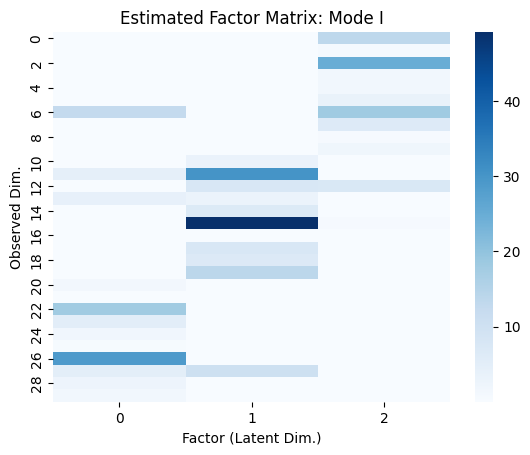

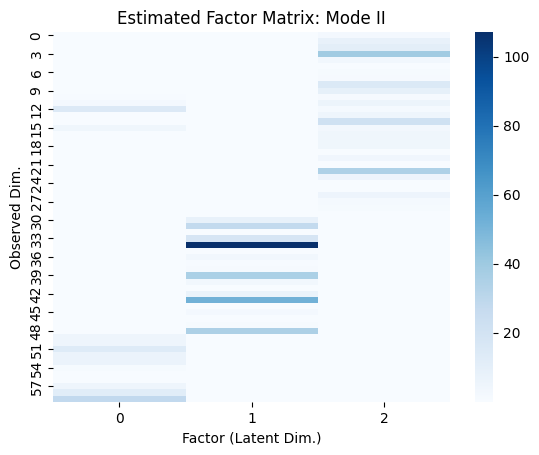

In [10]:
posterior_sample = posterior_samples[-1] #grab last sample to inspect
Phi1_IQ, Phi2_JQ = posterior_sample['factors'] #grab factor matrices
lambdas_Q = posterior_sample['lambdas'] #grab core tensor
indices_QM = posterior_sample['indices'] - 1 #julia indices to python indices
Y_Q = posterior_sample['Y'] #grab latent counts by class q

# plot factor matrix I
unique_indices = np.bincount(indices_QM[:, 0]) #determine which indices are used in factor matrix I
filtered = [x for x in unique_indices if x > 0] #filter out unused indices
sns.heatmap(Phi1_IQ[:,np.unique(indices_QM[:,0])]*filtered, cmap='Blues', xticklabels = np.unique(indices_QM[:,0])) #plot factor matrix I
plt.xlabel("Factor (Latent Dim.)")
plt.ylabel("Observed Dim.")
plt.title("Estimated Factor Matrix: Mode I")
plt.show()


#plot factor matrix II
unique_indices = np.bincount(indices_QM[:, 1]) #determine which indices are used in factor matrix II
filtered = [x for x in unique_indices if x > 0] #filter out unused indices
sns.heatmap(Phi2_JQ[:,np.unique(indices_QM[:,1])]*filtered, cmap='Blues', xticklabels = np.unique(indices_QM[:,1])) #plot factor matrix II
plt.xlabel("Factor (Latent Dim.)")
plt.ylabel("Observed Dim.")
plt.title("Estimated Factor Matrix: Mode II")
plt.show()



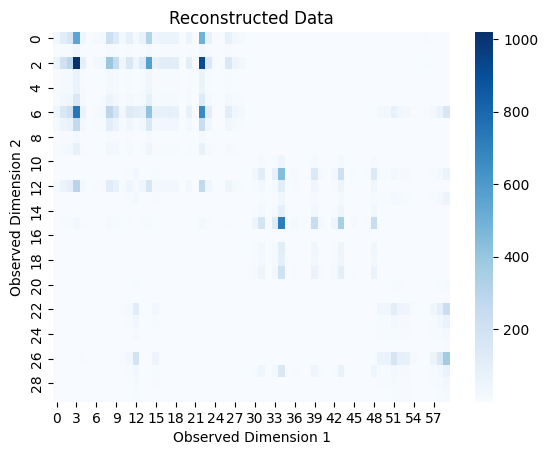

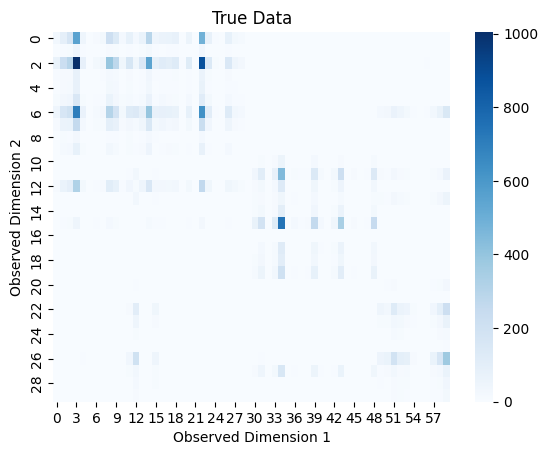

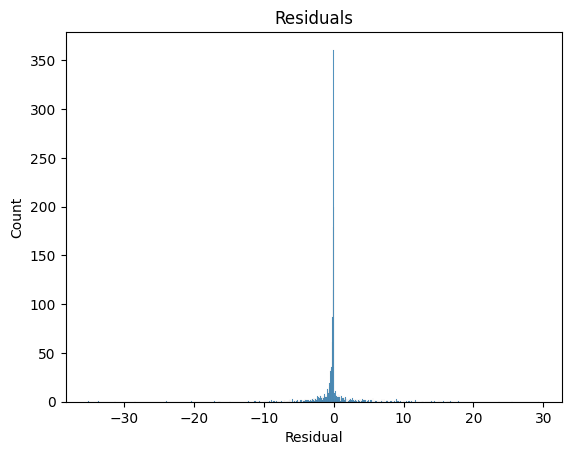

In [11]:
# plot reconstruction
reconstructed_IJ = (Phi1_IQ[:,indices_QM[:,0]]*lambdas_Q) @ Phi2_JQ[:,indices_QM[:,1]].T #reconstruct data
sns.heatmap((Phi1_IQ[:,indices_QM[:,0]]*lambdas_Q) @ Phi2_JQ[:,indices_QM[:,1]].T, cmap='Blues') #plot reconstructed data
plt.xlabel("Observed Dimension 1")
plt.ylabel("Observed Dimension 2")
plt.title("Reconstructed Data")
plt.show()

#plot data
sns.heatmap(Y_IJ, cmap="Blues") #plot true data
plt.xlabel("Observed Dimension 1")
plt.ylabel("Observed Dimension 2")
plt.title("True Data")
plt.show()

#plot residuals
sns.histplot((Y_IJ- reconstructed_IJ).reshape((np.prod(Y_IJ.shape),))) #plot residuals
plt.xlabel("Residual")
plt.title("Residuals")
plt.show()

The following cell plots the core values and allocated latent counts.

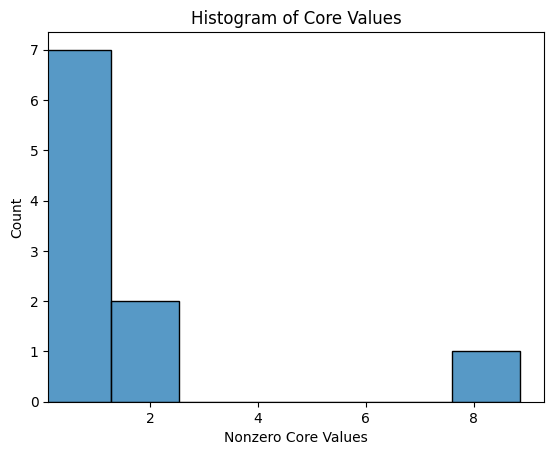

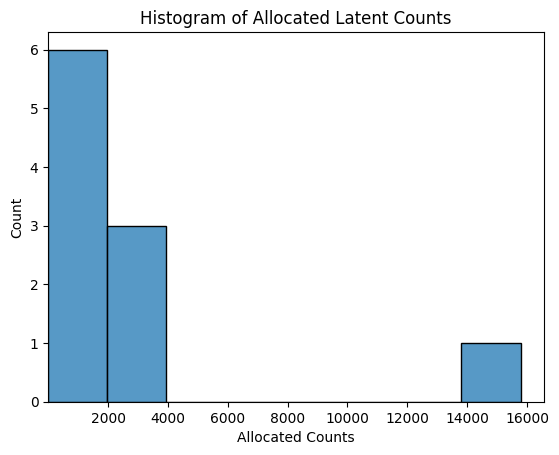

In [13]:
#plot core values
sns.histplot(lambdas_Q)
plt.xlabel("Nonzero Core Values")
plt.xlim(left=1e-1)
plt.title("Histogram of Core Values")
plt.show()

#plot allocated latent counts
sns.histplot(Y_Q)
plt.xlabel("Allocated Counts")
plt.xlim(left=1e-1)
plt.title("Histogram of Allocated Latent Counts")
plt.show()